Sampling rate estimation:

In [4]:
import os
import librosa
from collections import Counter

sr_list = []

DATASET_PATH = "data/raw/RAVDESS/"

for actor_folder in os.listdir(DATASET_PATH):
    actor_path = os.path.join(DATASET_PATH, actor_folder)

    if not os.path.isdir(actor_path):
        continue

    for filename in os.listdir(actor_path):
        if filename.endswith(".wav"):
            file_path = os.path.join(actor_path, filename)

            _, sr = librosa.load(file_path, sr=None)
            sr_list.append(sr)

# Count unique sampling rates
sr_distribution = Counter(sr_list)
print(sr_distribution)


Counter({48000: 1440})


SO all of the 1440 Audio files in the data, have been sampled at 48000

We empirically verified that all files are recorded at 48 kHz. Since emotional cues are concentrated below 10 kHz, we downsampled to 22.05 kHz, which preserves relevant spectral information while reducing redundancy and computational load.

22.05 kHz is the lowest sampling rate that comfortably preserves all emotion-relevant speech frequencies while significantly reducing computational cost, and it aligns with standard audio processing libraries.

In [5]:
import os
import librosa
import numpy as np
import pandas as pd

# ----------------------------
# Feature Extraction Function
# ----------------------------
def extract_features(audio_path, sr=22050):
    y, sr = librosa.load(
        audio_path,
        sr=sr,            # fixed sampling rate
        mono=True,
        duration=3.0
    )

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Delta & Delta-Delta
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)

    # Temporal aggregation (flattening)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    delta_mean = np.mean(delta_mfcc, axis=1)
    delta_std = np.std(delta_mfcc, axis=1)

    delta2_mean = np.mean(delta2_mfcc, axis=1)
    delta2_std = np.std(delta2_mfcc, axis=1)

    # Spectral features
    spectral_centroid = np.mean(
        librosa.feature.spectral_centroid(y=y, sr=sr)
    )
    spectral_rolloff = np.mean(
        librosa.feature.spectral_rolloff(y=y, sr=sr)
    )
    zero_crossing_rate = np.mean(
        librosa.feature.zero_crossing_rate(y)
    )

    # Final feature vector
    features = np.hstack([
        mfcc_mean, mfcc_std,
        delta_mean, delta_std,
        delta2_mean, delta2_std,
        spectral_centroid,
        spectral_rolloff,
        zero_crossing_rate
    ])

    return features


# ----------------------------
# Dataset Processing
# ----------------------------
all_features = []
all_labels = []

DATASET_PATH = "data/raw/RAVDESS/"

for actor_folder in os.listdir(DATASET_PATH):
    actor_path = os.path.join(DATASET_PATH, actor_folder)

    if not os.path.isdir(actor_path):
        continue

    for filename in os.listdir(actor_path):
        if filename.endswith(".wav"):
            file_path = os.path.join(actor_path, filename)

            # Emotion = 3rd identifier in filename
            emotion = int(filename.split("-")[2])

            features = extract_features(file_path)

            all_features.append(features)
            all_labels.append(emotion)


# ----------------------------
# Save to CSV
# ----------------------------
df = pd.DataFrame(all_features)
df["emotion"] = all_labels

df.to_csv("features.csv", index=False)

print("Feature extraction complete!")
print("Total samples:", len(df))
print("Feature dimension:", df.shape[1] - 1)


Feature extraction complete!
Total samples: 1440
Feature dimension: 81


### Emotion-wise Distribution Plots (correct + extensible)

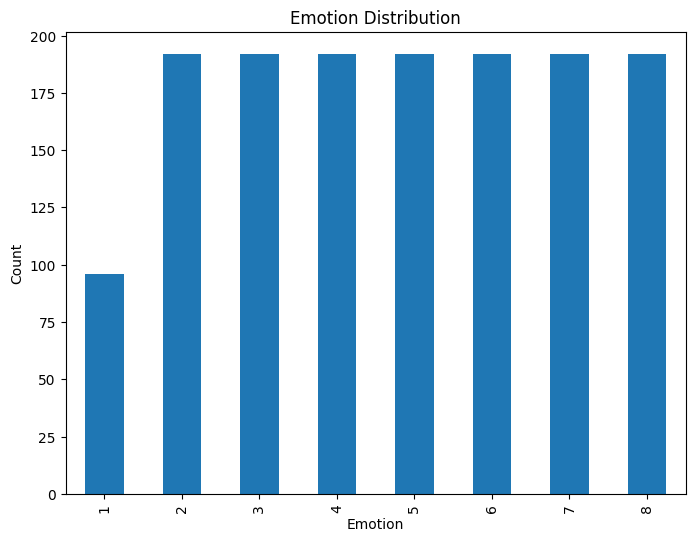

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("features.csv")

# Emotion distribution
plt.figure(figsize=(8, 6))
df["emotion"].value_counts().sort_index().plot(kind="bar")
plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

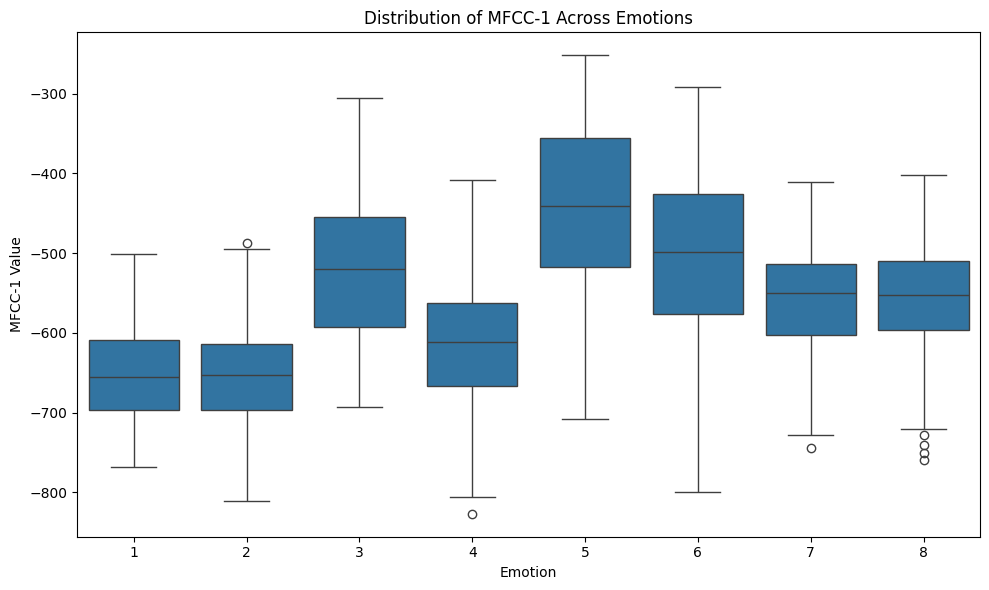

In [ ]:
# boxplots:
# Show spread, median, outliers
# Emotion differences become visible immediately

plt.figure(figsize=(10, 6))
sns.boxplot(x="emotion", y=df.columns[0], data=df)
plt.title("Distribution of MFCC-1 Across Emotions")
plt.xlabel("Emotion")
plt.ylabel("MFCC-1 Value")
plt.tight_layout()
plt.show()


### Correlation Heatmap

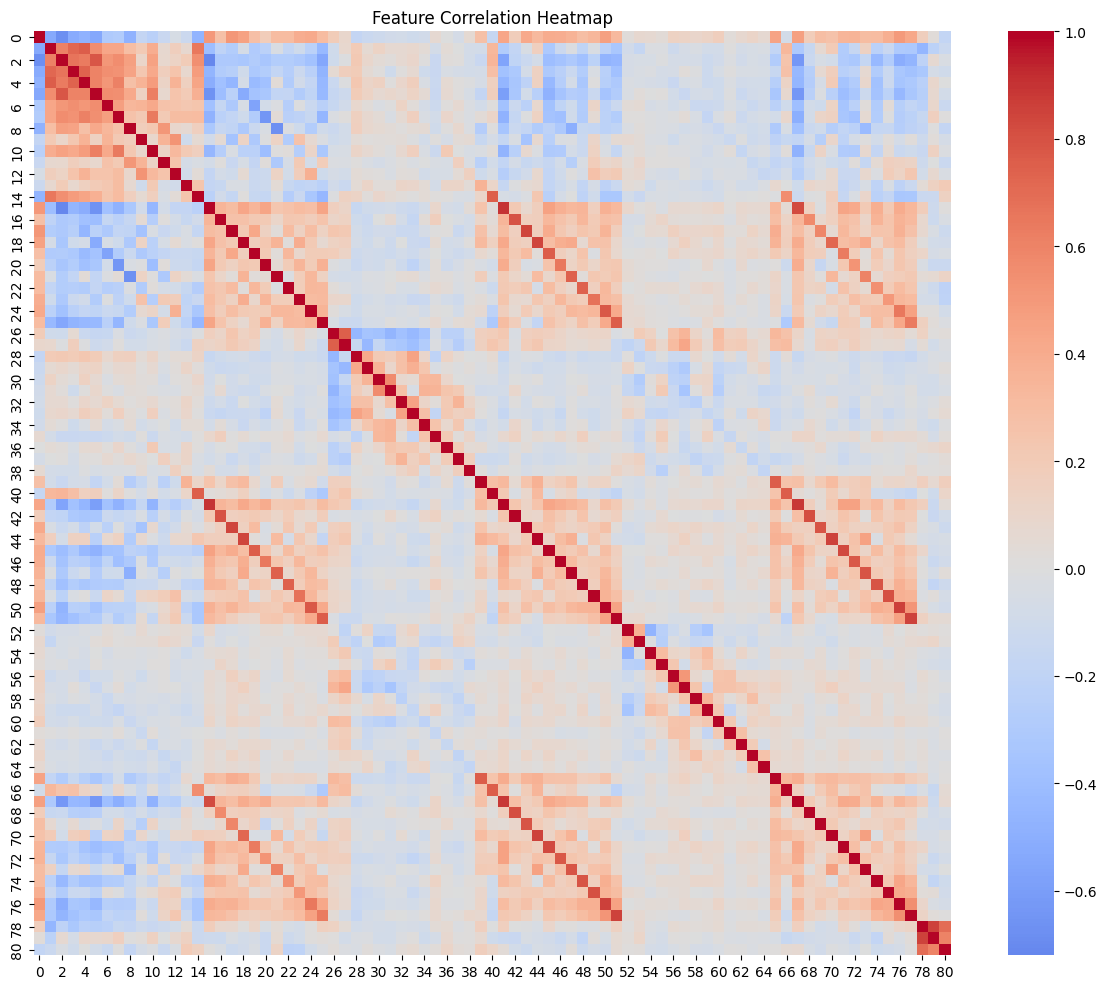

In [19]:
feature_df = df.drop(columns=["emotion"])

plt.figure(figsize=(12, 10))
correlation = feature_df.corr()
sns.heatmap(
    correlation,cmap="coolwarm",center=0,
)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# What you should observe:
# MFCCs cluster together
# Delta and Delta-Delta form blocks
# Spectral features are less correlated with MFCCs

## Identifying the Top 5 Most Discriminative Features
1. Measures between-class variance vs within-class variance
2. High F-score = strong emotion separation
3. Standard statistical technique

In [28]:
#  ANOVA F-score
from sklearn.feature_selection import f_classif

X = feature_df.values
y = df["emotion"].values

f_scores, p_values = f_classif(X, y)

feature_scores = pd.DataFrame({
    "feature": feature_df.columns,
    "f_score": f_scores,
    "p_value": p_values
})

top_5_features = feature_scores.sort_values(
    by="f_score", ascending=False
).head(5)

print(top_5_features)


              feature     f_score        p_value
0         mfcc_1_mean  138.441888  8.276153e-156
65  delta2_mfcc_1_std   77.119409   5.541023e-95
2         mfcc_3_mean   64.783569   3.374966e-81
1         mfcc_2_mean   50.780597   8.396956e-65
14         mfcc_2_std   48.037270   1.716562e-61


Visualising the Top Discriminative Features

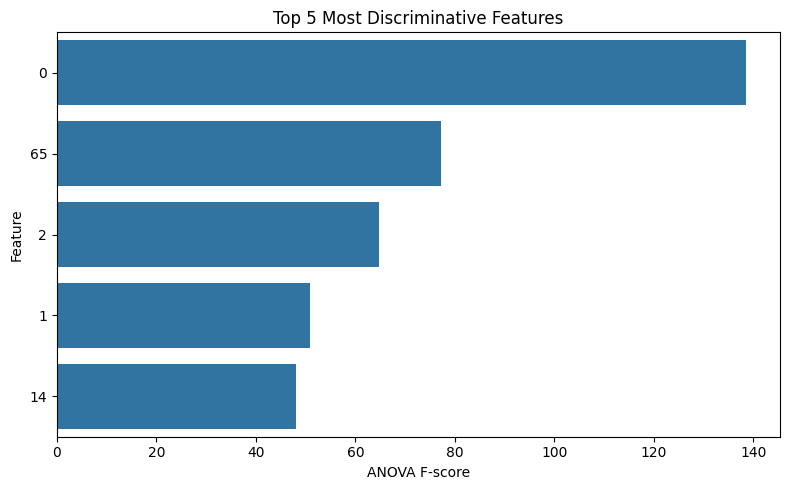

In [11]:
plt.figure(figsize=(8, 5))
sns.barplot(
    x="f_score",
    y="feature",
    data=top_5_features
)
plt.title("Top 5 Most Discriminative Features")
plt.xlabel("ANOVA F-score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Special note: “Advanced Analysis between Happy and Sad”

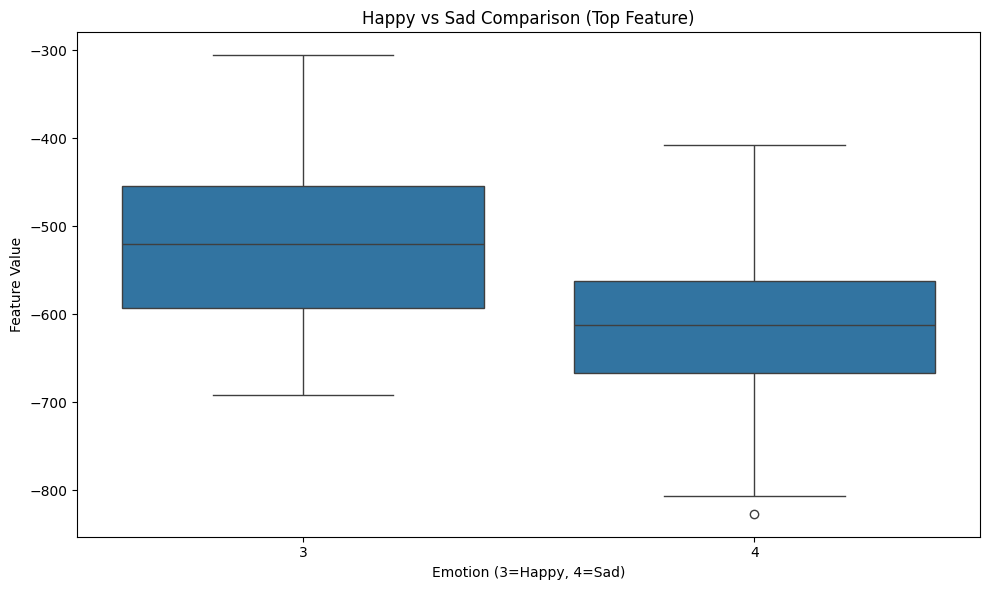

In [12]:
happy_sad_df = df[df["emotion"].isin([3, 4])]  # 3=happy, 4=sad

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="emotion",
    y=top_5_features.iloc[0]["feature"],
    data=happy_sad_df
)
plt.title("Happy vs Sad Comparison (Top Feature)")
plt.xlabel("Emotion (3=Happy, 4=Sad)")
plt.ylabel("Feature Value")
plt.tight_layout()
plt.show()
